# RCによる外力ありのVDPの予測を行う。

まず、ライブラリをインポートする。

In [94]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

VDPモデルを数値シミュレーションする。

timestepは2510に設定する。

（内訳：
学習期間は1000ステップ。

テスト期間は1000ステップ。

その後500ステップ弱をGenerative Modelで予測する。
）


In [95]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

In [98]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 7510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 7510))

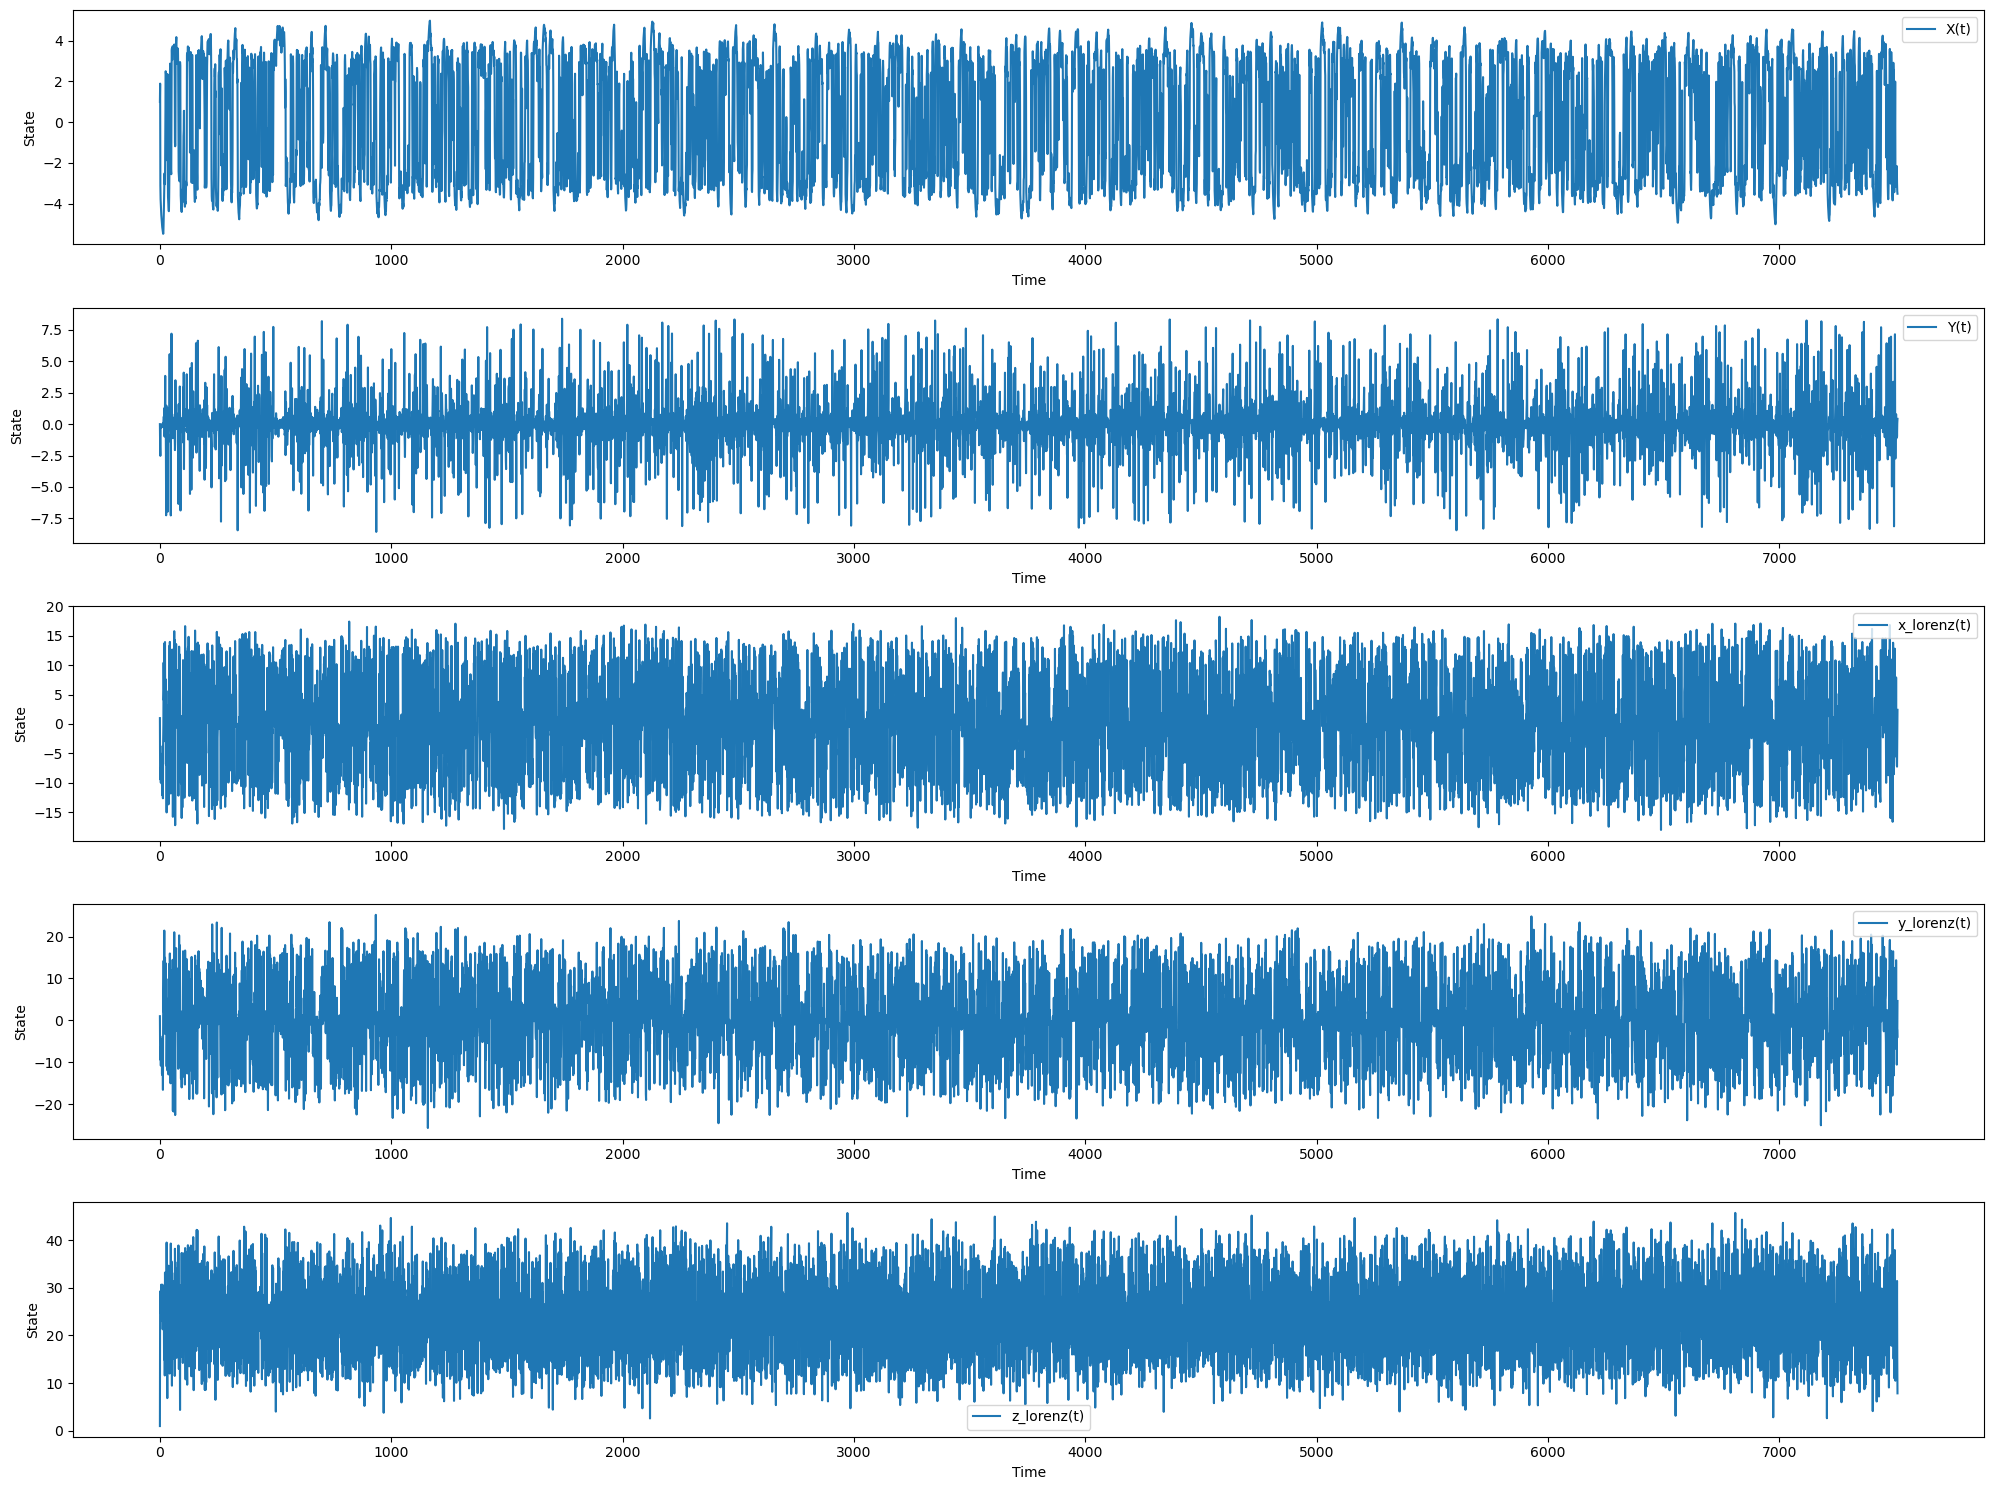

In [99]:
# Plot the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [101]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [102]:
X = data.values

In [103]:
X.shape

(7510, 5)

これで、2510にわたる、ローレンツモデルのx項を外力に持つVDPの配列を得ることができた。

#### 学習させるのは、どのパラメータ？

描画は後にする。

In [104]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [108]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 1000],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

データを準備する。

学習期間は6000ステップ。
テスト期間は1000ステップ。

In [109]:
from reservoirpy.datasets import to_forecasting

train_len = 6000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+1000], y[train_len:train_len+1000]
X_gen_test, y_gen_test = x[train_len+1000:], y[train_len+1000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [110]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

 46%|████▋     | 93/200 [06:36<09:54,  5.55s/trial, best loss: 0.07258508580019611]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.75632e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.10445e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 47%|████▋     | 94/200 [06:41<09:24,  5.33s/trial, best loss: 0.07258508580019611]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.05825e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



100%|██████████| 200/200 [14:29<00:00,  4.35s/trial, best loss: 0.07228836176502496]


学習対象を2つから5つに増やすと、予測精度が上がった。

In [111]:
best

({'N': 0,
  'iss': 0.19717791279794772,
  'lr': 0.8908311505278818,
  'ridge': 0.00013283966567113832,
  'seed': 0,
  'sr': 0.20760447792478667},
 <hyperopt.base.Trials at 0x16cc3c820>)

In [112]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.19717791279794772
lr = 0.8908311505278818
ridge = 0.00013283966567113832
seed = 1234
sr = 0.20760447792478667

In [113]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [114]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.07483146954883278
R^2: 0.7957368538095481


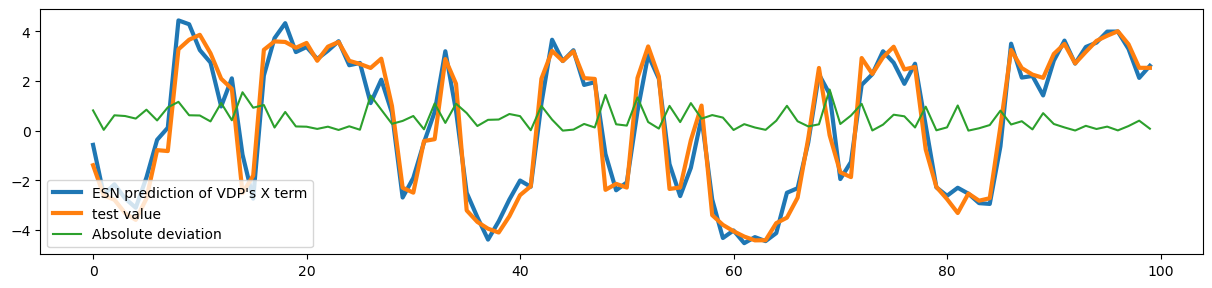

In [146]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

In [116]:
nrmse(y_test[:, :1], predictions[:, :1])

0.06015407104240036

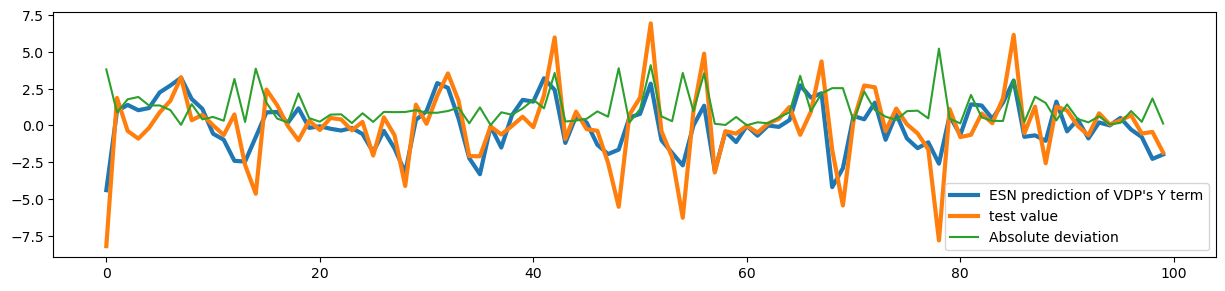

In [117]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

ここまで、通常の1期先予測の方法を見た。

さて、ここから、ESNに自分の予測に基づいて、100期先までを予測してもらう。

# Generative Modelを使う。

100期以前の情報を用いて、400期先までの予測を行う（実際気にするのはより小さい数）。

In [130]:
seed_timesteps = 1000

warming_inputs = X_train

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [133]:
warming_out[:, :1].shape

(6000, 1)

In [135]:
y_train[:, :1].shape

(6000, 1)

In [143]:
warming_out[:, :1][-1:]

array([[1.25437142]])

In [144]:
y_train[:, :1][-1:]

array([[2.31602149]])

In [137]:
nrmse(warming_out[:, :1], y_train[:, :1])

0.04787334538188376

### あと一桁下げる必要がある？

In [138]:
nb_generations = 509

X_gen = np.zeros((nb_generations, 5))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = model(y)
    X_gen[t, :] = y

過去一つを参照するとおかしくなる？

In [139]:
X_gen[:10][:, :1]

array([[ -2.52006589],
       [ -1.5202891 ],
       [  1.99099402],
       [  4.51170765],
       [  4.07265183],
       [  1.3972736 ],
       [ -0.32297518],
       [-41.89835428],
       [-49.39867592],
       [ -7.55181529]])

In [140]:
y_test[:10][:, :1]

array([[-1.38903181],
       [-2.60668311],
       [-2.77849368],
       [-3.32013526],
       [-3.58945371],
       [-2.73116944],
       [-0.78051935],
       [-0.81870266],
       [ 3.2788172 ],
       [ 3.66425667]])

In [126]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=100):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

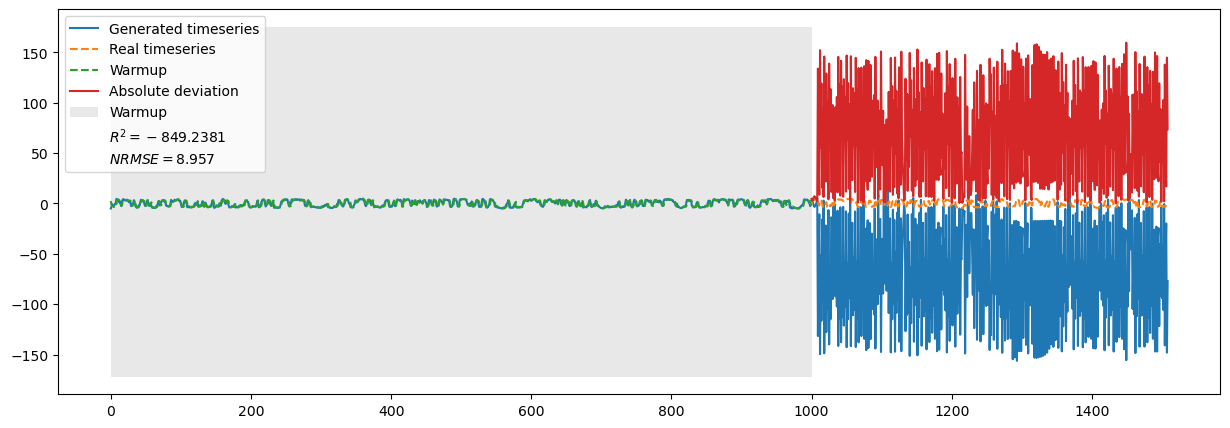

In [127]:
#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, :1], y_gen_test[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=1000)

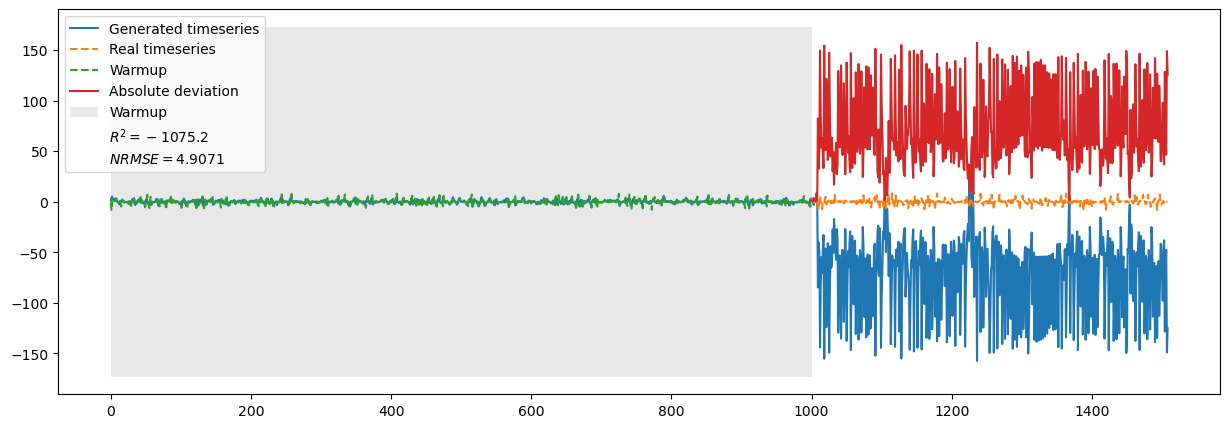

In [128]:
#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, 1:2], y_gen_test[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)